In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# Imports
import numpy as np
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

tf.logging.set_verbosity(tf.logging.INFO)

In [2]:
import inspect
import os

import numpy as np
import tensorflow as tf
import time

VGG_MEAN = [103.939, 116.779, 123.68]


class Vgg16:
    def __init__(self, vgg16_npy_path=None):
        if vgg16_npy_path is None:
            vgg16_npy_path = "vgg16.npy"
            print(vgg16_npy_path)

        self.data_dict = np.load(vgg16_npy_path, encoding='latin1').item()
        print("npy file loaded")

    def build(self, rgb, true_out=None):
        """
        load variable from npy to build the VGG
        :param rgb: rgb image [batch, height, width, 3] values scaled [0, 1]
        """

        start_time = time.time()
        print("build model started")
        rgb_scaled = rgb * 255.0

        # Convert RGB to BGR
        red, green, blue = tf.split(axis=3, num_or_size_splits=3, value=rgb_scaled)
        assert red.get_shape().as_list()[1:] == [224, 224, 1]
        assert green.get_shape().as_list()[1:] == [224, 224, 1]
        assert blue.get_shape().as_list()[1:] == [224, 224, 1]
        self.bgr = tf.concat(axis=3, values=[
            blue - VGG_MEAN[0],
            green - VGG_MEAN[1],
            red - VGG_MEAN[2],
        ])
        assert self.bgr.get_shape().as_list()[1:] == [224, 224, 3]

        self.conv1_1 = self.conv_layer(self.bgr, "conv1_1")
        self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
        self.pool1 = self.max_pool(self.conv1_2, 'pool1')

        self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
        self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
        self.pool2 = self.max_pool(self.conv2_2, 'pool2')

        self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
        self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
        self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")
        self.pool3 = self.max_pool(self.conv3_3, 'pool3')

        self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
        self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
        self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")
        self.pool4 = self.max_pool(self.conv4_3, 'pool4')

        self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
        self.conv5_2 = self.conv_layer(self.conv5_1, "conv5_2")
        self.conv5_3 = self.conv_layer(self.conv5_2, "conv5_3")
        self.pool5 = self.max_pool(self.conv5_3, 'pool5')

        self.fc6 = self.fc_layer(self.pool5, "fc6")
        assert self.fc6.get_shape().as_list()[1:] == [4096]
        self.relu6 = tf.nn.relu(self.fc6)

        self.fc7 = self.fc_layer(self.relu6, "fc7")
        self.relu7 = tf.nn.relu(self.fc7)

        self.fc8 = self.fc_layer(self.relu7, "fc8")

        self.prob = tf.nn.softmax(self.fc8, name="prob")
        
        self.cost = tf.reduce_sum((self.prob - true_out) ** 2)

        self.data_dict = None
        print(("build model finished: %ds" % (time.time() - start_time)))

    def avg_pool(self, bottom, name):
        return tf.nn.avg_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def max_pool(self, bottom, name):
        return tf.nn.max_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def conv_layer(self, bottom, name):
        with tf.variable_scope(name):
            filt = self.get_conv_filter(name)

            conv = tf.nn.conv2d(bottom, filt, [1, 1, 1, 1], padding='SAME')

            conv_biases = self.get_bias(name)
            bias = tf.nn.bias_add(conv, conv_biases)

            relu = tf.nn.relu(bias)
            return relu

    def fc_layer(self, bottom, name):
        with tf.variable_scope(name):
            shape = bottom.get_shape().as_list()
            dim = 1
            for d in shape[1:]:
                dim *= d
            x = tf.reshape(bottom, [-1, dim])

            weights = self.get_fc_weight(name)
            biases = self.get_bias(name)

            # Fully connected layer. Note that the '+' operation automatically
            # broadcasts the biases.
            fc = tf.nn.bias_add(tf.matmul(x, weights), biases)

            return fc

    def get_conv_filter(self, name):
        return tf.constant(self.data_dict[name][0], name="filter")

    def get_bias(self, name):
        return tf.constant(self.data_dict[name][1], name="biases")

    def get_fc_weight(self, name):
        return tf.constant(self.data_dict[name][0], name="weights")


In [3]:

import numpy as np
import cv2


# synset = [l.strip() for l in open('synset.txt').readlines()]


# returns image of shape [224, 224, 3]
# [height, width, depth]
def load_image(path):
    # load image
    img = cv2.imread(path)
    img = img / 255.0
    assert (0 <= img).all() and (img <= 1.0).all()
    # print "Original Image Shape: ", img.shape
    # we crop image from center
    #short_edge = min(img.shape[:2])
    #yy = int((img.shape[0] - short_edge) / 2)
    #xx = int((img.shape[1] - short_edge) / 2)
    #crop_img = img[yy: yy + short_edge, xx: xx + short_edge]
    # resize to 224, 224
    #resized_img =   cv2.resize(img, (224, 224))
    return img


# returns the top1 string
def print_prob(prob, file_path):
    synset = [l.strip() for l in open(file_path).readlines()]

    # print prob
    pred = np.argsort(prob)[::-1]
    print (len(pred))
    print (pred[0])
    # Get top1 label
    top1 = synset[pred[0]]
    
    print(("Top1: ", top1, prob[pred[0]]))
    # Get top5 label
    top5 = [(synset[pred[i]], prob[pred[i]]) for i in range(5)]
    print(("Top5: ", top5))
    return top1


def load_image2(path, height=None, width=None):
    # load image
    img = skimage.io.imread(path)
    img = img / 255.0
    if height is not None and width is not None:
        ny = height
        nx = width
    elif height is not None:
        ny = height
        nx = img.shape[1] * ny / img.shape[0]
    elif width is not None:
        nx = width
        ny = img.shape[0] * nx / img.shape[1]
    else:
        ny = img.shape[0]
        nx = img.shape[1]
    return skimage.transform.resize(img, (ny, nx))


def test():
    img = skimage.io.imread("./test_data/starry_night.jpg")
    ny = 300
    nx = img.shape[1] * ny / img.shape[0]
    img = skimage.transform.resize(img, (ny, nx))
    skimage.io.imsave("./test_data/test/output.jpg", img)


In [31]:

import numpy as np
import tensorflow as tf

img1 = load_image("car2.png")
img1 =   cv2.resize(img1, (224, 224))

batch1 = img1.reshape((1, 224, 224, 3))
#batch2 = img2.reshape((1, 224, 224, 3))

#batch = np.concatenate((batch1, batch2), 0)

# with tf.Session(config=tf.ConfigProto(gpu_options=(tf.GPUOptions(per_process_gpu_memory_fraction=0.7)))) as sess:
with tf.device('/cpu:0'):
    with tf.Session() as sess:
        images = tf.placeholder("float", [1, 224, 224, 3])
        feed_dict = {images: batch1}

        vgg = Vgg16()
        with tf.name_scope("content_vgg"):
            vgg.build(images, np.array([0 for j in range(1000)]))

        prob = sess.run(vgg.prob, feed_dict=feed_dict)
        #print(prob)
        print_prob(prob[0], 'synset.txt')
        #print_prob(prob[1], 'synset.txt')


vgg16.npy
npy file loaded
build model started
build model finished: 0s
1000
817
('Top1: ', 'n04285008 sports car, sport car', 0.7520982)
('Top5: ', [('n04285008 sports car, sport car', 0.7520982), ('n04037443 racer, race car, racing car', 0.07547117), ('n03100240 convertible', 0.049783736), ('n02814533 beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon', 0.019967113), ('n02974003 car wheel', 0.019608868)])


In [32]:
correct_pred = 817
enc = np.array([0 if i != correct_pred else 1 for i in range(1000)])



In [33]:
print (enc)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [34]:
tf.reset_default_graph()
            
with tf.device('/cpu:0'):
    with tf.Session() as sess:
        images = tf.placeholder("float", [1, 224, 224, 3])
        y = tf.placeholder("float", [1000])
        vgg = Vgg16()
        with tf.name_scope("content_vgg"):
            vgg.build(images, y)

            
        img1 = load_image("car2.png")
        img1 =   cv2.resize(img1, (256, 256))
        img_256 = cv2.resize(img1, (256, 256))

        saliency_256 = np.zeros((256, 256))
        saliency_256_count = np.zeros((256, 256))

        for i in range(0, 40, 16):
            for j in range(0, 40, 16):
           
                # print (img_256.shape)
                #print (str(i) + " " + str(j))
                img = img_256[i:i+224, j:j+224, :] 
                print (img.shape)

                batch1 = img.reshape((1, 224, 224, 3))
                feed_dict = {images: batch1, y: np.array(enc)}
                prob = sess.run(vgg.prob, feed_dict=feed_dict)
                cost = sess.run(vgg.cost, feed_dict=feed_dict)

                input_grad = sess.run(tf.gradients(vgg.cost, vgg.bgr), feed_dict=feed_dict)[0][0]
                input_grad = np.absolute(input_grad)
                input_grad *= -1     
                print (cost)        
                mx = [max(input_grad[ii][jj]) for ii in range(224) for jj in range(224)]
                #print (mx)

                nrows, ncols = 224, 224
                grid = np.reshape(mx, (nrows, ncols))
                for ii in range(224):
                    for jj in range(224):
                        #print (grid.shape)
                        saliency_256[i+ii][j+jj] += grid[ii][jj]
                        saliency_256_count[i+ii][j+jj] += 1

                


vgg16.npy
npy file loaded
build model started
build model finished: 0s
(224, 224, 3)
0.0128497
(224, 224, 3)
0.0185342
(224, 224, 3)
0.00594453
(224, 224, 3)
0.0322348
(224, 224, 3)
0.0430317
(224, 224, 3)
0.0218132
(224, 224, 3)
0.0305798
(224, 224, 3)
0.0519146
(224, 224, 3)
0.0362767


In [35]:
saliency_av = np.divide(saliency_256, saliency_256_count)

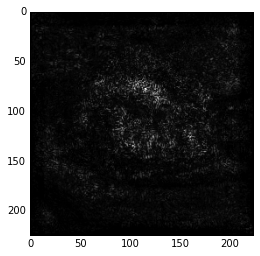

In [36]:
import numpy as np
import tensorflow as tf 
img1 =   cv2.resize(saliency_av, (224, 224))

plt.imshow(img1, interpolation='nearest', cmap='binary')
plt.show()

vgg16.npy
npy file loaded
build model started
build model finished: 0s
0.0362767


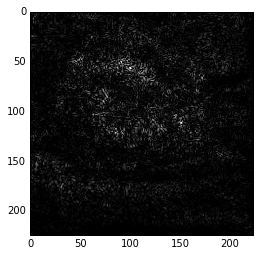

In [40]:
tf.reset_default_graph()
            
with tf.device('/cpu:0'):
    with tf.Session() as sess:
        images = tf.placeholder("float", [1, 224, 224, 3])
        y = tf.placeholder("float", [1000])
        vgg = Vgg16()
        with tf.name_scope("content_vgg"):
            vgg.build(images, y)

            
        img1 = load_image("car2.png")
        img1 =   cv2.resize(img1, (224, 224))

        batch1 = img.reshape((1, 224, 224, 3))
        feed_dict = {images: batch1, y: np.array(enc)}
        prob = sess.run(vgg.prob, feed_dict=feed_dict)
        cost = sess.run(vgg.cost, feed_dict=feed_dict)

        input_grad = sess.run(tf.gradients(vgg.cost, vgg.bgr), feed_dict=feed_dict)[0][0]
        input_grad = np.absolute(input_grad)
        input_grad *= -1     
        print (cost)        
        mx = [max(input_grad[ii][jj]) for ii in range(224) for jj in range(224)]
        #print (mx)

        nrows, ncols = 224, 224
        grid = np.reshape(mx, (nrows, ncols))
        plt.imshow(grid, interpolation='nearest', cmap='binary')
        plt.show()
                


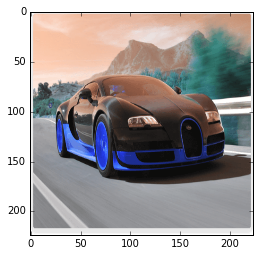

In [38]:
import numpy as np
import tensorflow as tf
tf.reset_default_graph() 
img1 = load_image("car2.png")
img1 =   cv2.resize(img1, (224, 224))

plt.imshow(img1)
plt.show()